This notebook details how to go from Datasets and DataFrames created by running experiment [scripts](../../scripts/) to data files used to produce the figures of the paper ...

Bare in mind that it involves manipulating large Datasets and therefore a system with a significant amount of RAM is recommended.

In [1]:
import sys

import IPython
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
# Works in VS-Code only, hard-code it if necessary
nb_dir = "/".join(
   IPython.extract_module_locals()[1]["__vsc_ipynb_file__"].split("/")[:-1]
)
sys.path.append(f"{nb_dir}/src")

from aggregate import max_of_n_time_rolling_mean
from binning import compute_spatial_binned_errors, compute_eke_binned_errors
from domain import remove_equatorial_band, restrict_df_to_neurost_timeperiod, restrict_ds_to_neurost_timeperiod
from interpolate import gridded_eke_to_drifters_observations

# Loading experiments Datasets and DataFrames

In [3]:
# CAN / SHOULD BE UPDATED TO REPRODUCE

EXPERIMENTS_PATH = "/mnt/summer/DATA_MEOM/workdir/bertrava/cyclogeostrophy-paper"

NEUROST_PATH = f"{EXPERIMENTS_PATH}/neurost-global/2025-02-07/14-50-54/results"
NEUROST_IT_PATH = f"{EXPERIMENTS_PATH}/neurost-global/2025-02-07/14-29-44/results"
DUACS_PATH = f"{EXPERIMENTS_PATH}/duacs-global/2025-02-07/14-56-12/results"
DUACS_IT_PATH = f"{EXPERIMENTS_PATH}/duacs-global/2025-02-09/10-55-14/results"

DATA_FILES_PATH = f"{nb_dir}/data-files"

In [4]:
def open_dataset(path: str) -> xr.Dataset:
    ds = xr.open_zarr(path)
    return remove_equatorial_band(ds)


def open_experiment_data(path: str) -> (xr.Dataset, xr.Dataset, pd.DataFrame):
    time_averaged_kinematics_ds = open_dataset(f"{path}/time_averaged_kinematics.zarr")
    all_times_kinematics_ds = open_dataset(f"{path}/all_times_kinematics.zarr")
    errors_to_drifters_df = pd.read_parquet(f"{path}/errors_to_drifters.parquet").drop_duplicates(
        subset=["lat", "lon", "time"]
    )
    return time_averaged_kinematics_ds, all_times_kinematics_ds, errors_to_drifters_df

In [5]:
neurost_time_averaged_kinematics_ds, neurost_all_times_kinematics_ds, neurost_errors_to_drifters_df = (
    open_experiment_data(NEUROST_PATH)
)
neurost_it_time_averaged_kinematics_ds, neurost_it_all_times_kinematics_ds, neurost_it_errors_to_drifters_df = (
    open_experiment_data(NEUROST_IT_PATH)
)
_, duacs_all_times_kinematics_ds, duacs_errors_to_drifters_df = (
    open_experiment_data(DUACS_PATH)
)
_, duacs_it_all_times_kinematics_ds, duacs_it_errors_to_drifters_df = (
    open_experiment_data(DUACS_IT_PATH)
)

In [6]:
duacs_all_times_kinematics_ds = restrict_ds_to_neurost_timeperiod(duacs_all_times_kinematics_ds)
duacs_errors_to_drifters_df = restrict_df_to_neurost_timeperiod(duacs_errors_to_drifters_df)
duacs_it_all_times_kinematics_ds = restrict_ds_to_neurost_timeperiod(duacs_it_all_times_kinematics_ds)
duacs_it_errors_to_drifters_df = restrict_df_to_neurost_timeperiod(duacs_it_errors_to_drifters_df)

# Cyclogeostrophic imbalance

In [7]:
# Can be adjusted to better align with system RAM & GPU
CHUNKS = {"time": -1, "latitude": 100, "longitude": 200}


def get_uv_imbalance_dataarrays(ds: xr.Dataset) -> (xr.DataArray, xr.DataArray):
    imbalance_uv_Geostrophy = ds.imbalance_uv_Geostrophy
    imbalance_uv_Geostrophy = imbalance_uv_Geostrophy.chunk(**CHUNKS)
    imbalance_uv_Cyclogeostrophy = ds.imbalance_uv_Cyclogeostrophy
    imbalance_uv_Cyclogeostrophy = imbalance_uv_Cyclogeostrophy.chunk(**CHUNKS)
    return imbalance_uv_Geostrophy, imbalance_uv_Cyclogeostrophy

In [8]:
neurost_imbalance_uv_Geostrophy, neurost_imbalance_uv_Cyclogeostrophy = get_uv_imbalance_dataarrays(
    neurost_all_times_kinematics_ds
)
neurost_it_imbalance_uv_Geostrophy, neurost_it_imbalance_uv_Cyclogeostrophy = get_uv_imbalance_dataarrays(
    neurost_it_all_times_kinematics_ds
)
duacs_imbalance_uv_Geostrophy, duacs_imbalance_uv_Cyclogeostrophy = get_uv_imbalance_dataarrays(
    duacs_all_times_kinematics_ds
)
duacs_it_imbalance_uv_Geostrophy, duacs_it_imbalance_uv_Cyclogeostrophy = get_uv_imbalance_dataarrays(
    duacs_it_all_times_kinematics_ds
)

In [9]:
N_DAYS = 7  # Iannou et al. used 5


def apply_time_agregation(
    imbalance_uv_Geostrophy: xr.DataArray, imbalance_uv_Cyclogeostrophy: xr.DataArray
) -> (xr.DataArray, xr.DataArray):
    imbalance_uv_Geostrophy = max_of_n_time_rolling_mean(imbalance_uv_Geostrophy, n_time=N_DAYS)
    imbalance_uv_Cyclogeostrophy = max_of_n_time_rolling_mean(imbalance_uv_Cyclogeostrophy, n_time=N_DAYS)
    return imbalance_uv_Geostrophy, imbalance_uv_Cyclogeostrophy

In [10]:
neurost_imbalance_uv_Geostrophy, neurost_imbalance_uv_Cyclogeostrophy = apply_time_agregation(
    neurost_imbalance_uv_Geostrophy, neurost_imbalance_uv_Cyclogeostrophy
)
neurost_it_imbalance_uv_Geostrophy, neurost_it_imbalance_uv_Cyclogeostrophy = apply_time_agregation(
    neurost_it_imbalance_uv_Geostrophy, neurost_it_imbalance_uv_Cyclogeostrophy
)
duacs_imbalance_uv_Geostrophy, duacs_imbalance_uv_Cyclogeostrophy = apply_time_agregation(
    duacs_imbalance_uv_Geostrophy, duacs_imbalance_uv_Cyclogeostrophy
)
duacs_it_imbalance_uv_Geostrophy, duacs_it_imbalance_uv_Cyclogeostrophy = apply_time_agregation(
    duacs_it_imbalance_uv_Geostrophy, duacs_it_imbalance_uv_Cyclogeostrophy
)

In [11]:
def save_uv_imbalance_dataarrays(
    imbalance_uv_Geostrophy: xr.DataArray, imbalance_uv_Cyclogeostrophy: xr.DataArray, experiment: str
):
    imbalance_uv_Geostrophy.to_netcdf(f"{DATA_FILES_PATH}/{experiment}_imbalance_uv_Geostrophy.nc")
    imbalance_uv_Cyclogeostrophy.to_netcdf(f"{DATA_FILES_PATH}/{experiment}_imbalance_uv_Cyclogeostrophy.nc")

In [13]:
save_uv_imbalance_dataarrays(
    neurost_imbalance_uv_Geostrophy, neurost_imbalance_uv_Cyclogeostrophy, "neurost"
)
save_uv_imbalance_dataarrays(
    neurost_it_imbalance_uv_Geostrophy, neurost_it_imbalance_uv_Cyclogeostrophy, "neurost_it"
)
save_uv_imbalance_dataarrays(
    duacs_imbalance_uv_Geostrophy, duacs_imbalance_uv_Cyclogeostrophy, "duacs"
)
save_uv_imbalance_dataarrays(
    duacs_it_imbalance_uv_Geostrophy, duacs_it_imbalance_uv_Cyclogeostrophy, "duacs_it"
)

/home/bertrava/miniconda3/envs/cyclogeostrophy_impact_experiment/lib/python3.11/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/bertrava/miniconda3/envs/cyclogeostrophy_impact_experiment/lib/python3.11/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/bertrava/miniconda3/envs/cyclogeostrophy_impact_experiment/lib/python3.11/site-packages/dask/array/reductions.py:655: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


# EKE relative difference

In [7]:
def get_neurost_eke_diff_dataarray(ds: xr.Dataset) -> xr.DataArray:
    return ds.eke_diff_rel_Cyclogeostrophy_Geostrophy

In [8]:
neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy = get_neurost_eke_diff_dataarray(neurost_time_averaged_kinematics_ds)
neurost_it_eke_diff_rel_Cyclogeostrophy_Geostrophy = get_neurost_eke_diff_dataarray(
    neurost_it_time_averaged_kinematics_ds
)

In [9]:
def get_duacs_eke_diff_dataarray(ds: xr.Dataset) -> xr.DataArray:
    eke_Cyclogeostrophy = ds.eke_Cyclogeostrophy.mean(dim="time")
    eke_Geostrophy = ds.eke_Geostrophy.mean(dim="time")
    return (eke_Cyclogeostrophy - eke_Geostrophy) / eke_Geostrophy * 100

In [10]:
duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy = get_duacs_eke_diff_dataarray(duacs_all_times_kinematics_ds)
duacs_it_eke_diff_rel_Cyclogeostrophy_Geostrophy = get_duacs_eke_diff_dataarray(duacs_it_all_times_kinematics_ds)

In [11]:
def save_eke_diff_dataarray(da: xr.DataArray, experiment: str):
    da.to_netcdf(f"{DATA_FILES_PATH}/{experiment}_eke_diff_rel_Cyclogeostrophy_Geostrophy.nc")

In [12]:
save_eke_diff_dataarray(duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy, "duacs")
save_eke_diff_dataarray(duacs_it_eke_diff_rel_Cyclogeostrophy_Geostrophy, "duacs_it")

In [13]:
save_eke_diff_dataarray(neurost_eke_diff_rel_Cyclogeostrophy_Geostrophy, "neurost")
save_eke_diff_dataarray(neurost_it_eke_diff_rel_Cyclogeostrophy_Geostrophy, "neurost_it")
save_eke_diff_dataarray(duacs_eke_diff_rel_Cyclogeostrophy_Geostrophy, "duacs")
save_eke_diff_dataarray(duacs_it_eke_diff_rel_Cyclogeostrophy_Geostrophy, "duacs_it")

# Ocean surface snapshots

In [ ]:
SNAPSHOT_DAY = "2015-05-16"


def get_snapshot(ds: xr.Dataset) -> xr.Dataset:
    return ds[[
        "magn_Cyclogeostrophy", "magn_Geostrophy", 
        "nrv_Cyclogeostrophy", "nrv_Geostrophy"
    ]].sel(
        time=SNAPSHOT_DAY
    )

In [ ]:
snapshot_neurost = get_snapshot(neurost_all_times_kinematics_ds)
snapshot_neurost_it = get_snapshot(neurost_it_all_times_kinematics_ds)
snapshot_duacs = get_snapshot(duacs_all_times_kinematics_ds)
snapshot_duacs_it = get_snapshot(duacs_it_all_times_kinematics_ds)

In [ ]:
def save_snapshot(snapshot_ds: xr.Dataset, experiment: str):
    snapshot_ds.to_netcdf(f"{DATA_FILES_PATH}/{experiment}_snapshot.nc")

In [ ]:
save_snapshot(snapshot_neurost, "neurost")
save_snapshot(snapshot_neurost_it, "neurost_it")
save_snapshot(snapshot_duacs, "duacs")
save_snapshot(snapshot_duacs_it, "duacs_it")

# Binned Sea Surface Currents errors to drifters

In [7]:
neurost_errors_to_drifters_df = neurost_errors_to_drifters_df.merge(
    duacs_errors_to_drifters_df[["lat", "lon", "time"]], how="inner", on=["lat", "lon", "time"]
)
duacs_errors_to_drifters_df = duacs_errors_to_drifters_df.merge(
    neurost_errors_to_drifters_df[["lat", "lon", "time"]], how="inner", on=["lat", "lon", "time"]
)
neurost_it_errors_to_drifters_df = neurost_it_errors_to_drifters_df.merge(
    duacs_errors_to_drifters_df[["lat", "lon", "time"]], how="inner", on=["lat", "lon", "time"]
)
duacs_it_errors_to_drifters_df = duacs_it_errors_to_drifters_df.merge(
    duacs_errors_to_drifters_df[["lat", "lon", "time"]], how="inner", on=["lat", "lon", "time"]
)

In [8]:
BIN_SIZE = 1  # in °
MIN_OBS = 200


def get_spatial_binned_errors(df: pd.DataFrame) -> xr.Dataset:
    latitude = np.arange(-90, 90, BIN_SIZE) + (BIN_SIZE / 2)
    longitude = np.arange(-180, 180, BIN_SIZE) + (BIN_SIZE / 2)

    ds = compute_spatial_binned_errors(df, latitude, longitude)
    ds = remove_equatorial_band(ds)
    ds = ds.where(ds["count"] >= MIN_OBS)  # discard bins with "too few" observations

    return ds

In [16]:
neurost_spatial_binned_errors = get_spatial_binned_errors(neurost_errors_to_drifters_df)
neurost_it_spatial_binned_errors = get_spatial_binned_errors(neurost_it_errors_to_drifters_df)
duacs_spatial_binned_errors = get_spatial_binned_errors(duacs_errors_to_drifters_df)
duacs_it_spatial_binned_errors = get_spatial_binned_errors(duacs_it_errors_to_drifters_df)

In [17]:
def save_spatial_binned_errors_dataset(spatial_binned_errors_ds: xr.Dataset, experiment: str):
    spatial_binned_errors_ds.to_netcdf(
        f"{DATA_FILES_PATH}/{experiment}_spatial_binned_errors_ds.nc"
    )

In [18]:
save_spatial_binned_errors_dataset(neurost_spatial_binned_errors, "neurost")
save_spatial_binned_errors_dataset(neurost_it_spatial_binned_errors, "neurost_it")
save_spatial_binned_errors_dataset(duacs_spatial_binned_errors, "duacs")
save_spatial_binned_errors_dataset(duacs_it_spatial_binned_errors, "duacs_it")

# Sea Surface Currents errors to drifters as a function of EKE

In [9]:
# To avoid interpolating EKE to drifters positions several times as it is very costly, we sort the DataFrames first
neurost_errors_to_drifters_df = neurost_errors_to_drifters_df.sort_values(by=["time", "lon", "lat"])
neurost_it_errors_to_drifters_df = neurost_it_errors_to_drifters_df.sort_values(by=["time", "lon", "lat"])
duacs_errors_to_drifters_df = duacs_errors_to_drifters_df.sort_values(by=["time", "lon", "lat"])
duacs_it_errors_to_drifters_df = duacs_it_errors_to_drifters_df.sort_values(by=["time", "lon", "lat"])

In [10]:
# Chunking can be adjusted to better align with system RAM & GPU
eke_Cyclogeostrophy = neurost_all_times_kinematics_ds.eke_Cyclogeostrophy.chunk(time=500, latitude=450, longitude=900)
eke_Cyclogeostrophy.longitude.attrs["units"] = "degrees_east"
eke_Cyclogeostrophy.latitude.attrs["units"] = "degrees_north"

# Same for all
eke_drifter_observations = gridded_eke_to_drifters_observations(eke_Cyclogeostrophy, neurost_errors_to_drifters_df)

In [11]:
INTER_QUANTILE = .01

eke_quantiles = np.quantile(
    eke_drifter_observations[np.isfinite(eke_drifter_observations)], 
    np.arange(0, 1, INTER_QUANTILE) + (INTER_QUANTILE / 2)
)

(array([9351204.,  238674.,   64161.,   27302.]),
 array([0. , 0.1, 0.2, 0.3, 0.4]),
 <BarContainer object of 4 artists>)

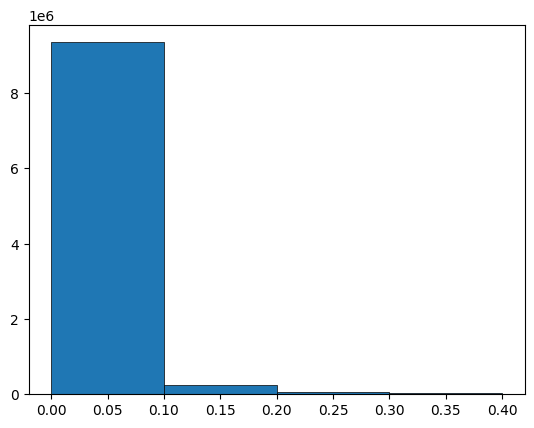

In [ ]:
import matplotlib.pyplot as plt

plt.hist(
    eke_drifter_observations[np.isfinite(eke_drifter_observations)],
    edgecolor="black",
    bins=[0, 0.1, 0.2, 0.3, 0.4],
    linewidth=0.5,
)

In [14]:
eke_quantiles

array([2.52986160e-05, 6.25714328e-05, 9.98617194e-05, 1.38573700e-04,
       1.79045726e-04, 2.21789248e-04, 2.66151296e-04, 3.12627988e-04,
       3.61239984e-04, 4.12702827e-04, 4.65623600e-04, 5.21051115e-04,
       5.78915532e-04, 6.38370709e-04, 7.00610475e-04, 7.65816722e-04,
       8.33913794e-04, 9.03985740e-04, 9.76691873e-04, 1.05258083e-03,
       1.13116940e-03, 1.21257432e-03, 1.29719258e-03, 1.38474233e-03,
       1.47606654e-03, 1.56942342e-03, 1.66701231e-03, 1.76766465e-03,
       1.87211852e-03, 1.97965484e-03, 2.09170433e-03, 2.20732323e-03,
       2.32725880e-03, 2.45127177e-03, 2.57987694e-03, 2.71491487e-03,
       2.85357598e-03, 2.99714466e-03, 3.14612630e-03, 3.30210752e-03,
       3.46261249e-03, 3.63036576e-03, 3.80402133e-03, 3.98480832e-03,
       4.17235426e-03, 4.36798793e-03, 4.57158542e-03, 4.78492790e-03,
       5.00418833e-03, 5.23275610e-03, 5.47238577e-03, 5.72361591e-03,
       5.98432978e-03, 6.25497783e-03, 6.53953885e-03, 6.83493263e-03,
      

In [30]:
def extract_percentile_bins(df):
    selected_entries = []

    for i in [-11, -5, -2, -1]:
        if i == 0:
            lower = -np.inf
        else:
            lower = 0.5 * (eke_quantiles[i] + eke_quantiles[i - 1])
        
        if i == -1:
            upper = np.inf
        else:
            upper = 0.5 * (eke_quantiles[i] + eke_quantiles[i + 1])
        
        entries_in_bin = df[(eke_drifter_observations >= lower) & (eke_drifter_observations < upper)]
        entries_in_bin = entries_in_bin[["err_Cyclogeostrophy", "err_Geostrophy"]]
        entries_in_bin["eke"] = eke_quantiles[i]
        selected_entries.append(entries_in_bin)

    return pd.concat(selected_entries, ignore_index=True)

In [31]:
neurost_eke_errors = extract_percentile_bins(neurost_errors_to_drifters_df)
neurost_it_eke_errors = extract_percentile_bins(neurost_it_errors_to_drifters_df)
duacs_eke_errors = extract_percentile_bins(duacs_errors_to_drifters_df)
duacs_it_eke_errors = extract_percentile_bins(duacs_it_errors_to_drifters_df)

In [32]:
neurost_eke_errors["eke"].unique()

array([0.04419339, 0.08819784, 0.18555086, 0.35066897])

In [33]:
def save_eke_errors(eke_errors: pd.DataFrame, experiment: str):
    eke_errors.to_parquet(f"{DATA_FILES_PATH}/{experiment}_eke_errors.parquet")

In [34]:
save_eke_errors(neurost_eke_errors, "neurost")
save_eke_errors(neurost_it_eke_errors, "neurost_it")
save_eke_errors(duacs_eke_errors, "duacs")
save_eke_errors(duacs_it_eke_errors, "duacs_it")

In [ ]:
def get_eke_binned_errors(errors_df) -> xr.Dataset:
    return compute_eke_binned_errors(errors_df, eke_drifter_observations, eke_quantiles)

In [22]:
neurost_eke_binned_errors = get_eke_binned_errors(neurost_errors_to_drifters_df)
neurost_it_eke_binned_errors = get_eke_binned_errors(neurost_it_errors_to_drifters_df)
duacs_eke_binned_errors = get_eke_binned_errors(duacs_errors_to_drifters_df)
duacs_it_eke_binned_errors = get_eke_binned_errors(duacs_it_errors_to_drifters_df)

In [23]:
def save_eke_binned_errors(eke_binned_errors: xr.Dataset, experiment: str):
    eke_binned_errors.to_netcdf(f"{DATA_FILES_PATH}/{experiment}_eke_binned_errors.nc")

In [24]:
save_eke_binned_errors(neurost_eke_binned_errors, "neurost")
save_eke_binned_errors(neurost_it_eke_binned_errors, "neurost_it")
save_eke_binned_errors(duacs_eke_binned_errors, "duacs")
save_eke_binned_errors(duacs_it_eke_binned_errors, "duacs_it")